# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana.app")

Mono path[0] = '/Users/dmitrimanajev/Dev_Code/Udacity/Deep_Reinforcement2/Value-based-methods/p1_navigation/Banana.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/dmitrimanajev/Dev_Code/Udacity/Deep_Reinforcement2/Value-based-methods/p1_navigation/Banana.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
````

In [5]:
from dqn_agent import Agent

agent = Agent(name="Test", state_size=state_size, action_size=action_size, learning_rate=2.5e-4, batch_size=128, is_double=True, is_prioritzed=True)

# watch an untrained agent
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0  
for j in range(5):
    action = agent.act(state)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    agent.step(state, action, reward, next_state, done)
    score += reward                                # update the score
    state = next_state    
    if done:
        break 

print("Score: {}".format(score))


MPS backend is available. Using MPS.
Score: 0.0


We going to implement a Deep Q-Learning (DQN) training loop and a logging function:

- **`log_to_json`**: Saves agent parameters and episode data to a JSON file, allowing for tracking and reloading of experiment details.
- **`dqn`**: Runs a DQN training loop where an agent interacts with an environment over multiple episodes.  
  - It adjusts exploration (epsilon-greedy policy), tracks performance, and saves the model whenever it achieves a new best average score. 
  - The training stops once the agent consistently achieves a target score, marking the environment as "solved."

In [ ]:
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import json
import os

def log_to_json(file_path, agent_name, params, episode_data):
    # Step 1: Load existing data if the file exists and is non-empty
    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        with open(file_path, 'r') as file:
            data = json.load(file)
    else:
        data = {}  # Initialize as empty if the file doesn’t exist or is empty

    # Step 2: Update data with new information
    if agent_name not in data:
        data[agent_name] = {"parameters": params, "episodes_data": {}}
    
    # Add episode data as a new trial
    data[agent_name]["episodes_data"] = episode_data

    # Step 3: Write updated data back to the file
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=2, separators=(',', ': '))


def dqn(agent, n_episodes=1500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    best_average = -float('inf')       # track best average score
    best_model_path = None             # store path of the best model
    is_solved = False                  # solved when has > 15 score
    episodes_to_solve = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        avg_score = np.mean(scores_window)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))

        # Stop if environment is solved
        if avg_score >= 15:
            if not is_solved:
                print(f'\nEnvironment solved in {i_episode - 100} episodes!\tAverage Score: {avg_score:.2f}')
                is_solved = True
                episodes_to_solve = i_episode - 100
            # Check if current average is the best so far
            if avg_score > best_average:
                best_average = avg_score
                # Define a filename for saving model based on parameters
                best_model_path = f'checkpoint_{agent.name}.pth'
                torch.save(agent.qnetwork_local.state_dict(), best_model_path)
                print(f'\nBest model saved with average score: {best_average:.2f} at {best_model_path}')

    return scores, best_average, episodes_to_solve



Next, we’re setting up and training our Dueling DDQN agent, then logging and visualizing the results:

- **Initialize the Agent**: We create an agent with a **Dueling Double DQN** architecture. This setup combines several enhancements:
  - **Dueling DQN** helps the agent distinguish between important states.
  - **Double DQN** reduces the risk of overestimating Q-values, making training more stable.

- **Run Training**: We use the `dqn` function to train the agent, which returns:
  - `scores`: Episode-by-episode scores to track progress.
  - `best_average`: The highest average score achieved during training.
  - `episodes_to_solve`: The number of episodes needed to reach the target score consistently, meaning the environment is "solved."

- **Log Training Data**: All key data (parameters and episode results) is saved to a JSON file (`performance.json`) for easy access and review.

- **Plot the Results**: Finally, we visualize the scores across episodes to observe the agent's performance and improvement over time.

MPS backend is available. Using MPS.
Episode 100	Average Score: 0.66
Episode 200	Average Score: 3.22
Episode 300	Average Score: 7.00
Episode 400	Average Score: 10.48
Episode 500	Average Score: 13.89
Episode 600	Average Score: 14.73
Episode 614	Average Score: 15.02
Environment solved in 514 episodes!	Average Score: 15.02

Best model saved with average score: 15.02 at checkpoint_Dueling DDQN.pth
Episode 615	Average Score: 15.05
Best model saved with average score: 15.05 at checkpoint_Dueling DDQN.pth
Episode 654	Average Score: 15.08
Best model saved with average score: 15.08 at checkpoint_Dueling DDQN.pth
Episode 655	Average Score: 15.13
Best model saved with average score: 15.13 at checkpoint_Dueling DDQN.pth
Episode 656	Average Score: 15.22
Best model saved with average score: 15.22 at checkpoint_Dueling DDQN.pth
Episode 658	Average Score: 15.30
Best model saved with average score: 15.30 at checkpoint_Dueling DDQN.pth
Episode 659	Average Score: 15.31
Best model saved with average score

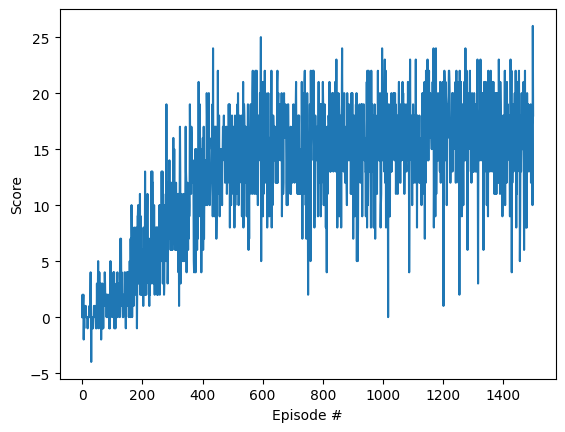

In [ ]:
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, name='Dueling DDQN', is_double=True, is_prioritzed=False, is_dueling=True)

scores, best_average, episodes_to_solve = dqn(agent)
log_to_json('performance.json', 'Dueling DDQN', {
    "BUFFER_SIZE": int(1e5),
    "BATCH_SIZE": 64, 
    "GAMMA": 1,
    "TAU": 1e-3,
    "LR": 5e-4, # may be last change
    "UPDATE_EVERY": 4,
}, {
    "episodes": scores,
    "best_average": best_average,
    "episodes_to_solve": episodes_to_solve
})
#   Reduced learning rate for stability

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


This code sets up an episode in the Unity Banana environment and enables recording via an external screen recorder due to the lack of direct visual observations:

- **Set Up the Environment**: 
  - Initializes the Unity environment (`Banana.app`) and retrieves the main "brain" responsible for agent interactions.

- **Recording Setup**:
  - Specifies the file name for the video output (`agent_performance.gif` or `.mp4`) and sets the frames per second (`fps`).
  - Since the environment lacks visual output, an external screen recording tool (e.g., **Gifox**, **GIF Brewery**, or **GIPHY Capture**) will be used to capture the display directly.

- **Run the Episode**:
  - Resets the environment in view mode (non-training mode) to enable visual monitoring.
  - Starts the screen recorder (manually or programmatically, if possible).
  - The loop runs where the agent performs actions based on its policy:
    - The agent takes an action, and the environment responds with the next state and reward.
    - Although normally frames would be captured programmatically, here the external screen recorder captures the window display instead.
  - The loop breaks when the episode ends.

- **Save the Video**:
  - After the episode concludes, stop the screen recording. The recording tool will save the video in the specified format.

- **Clean Up**:
  - Closes the environment when done.

This setup allows you to observe the agent’s performance visually with the screen recorder capturing the interaction from the Unity application window.

In [1]:
from unityagents import UnityEnvironment
from dqn_agent import Agent
import numpy as np
import imageio
import time
import torch

# Initialize Unity environment
env = UnityEnvironment(file_name="Banana.app")

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Parameters for recording
video_file = "agent_performance.gif"  # change to .mp4 for video
fps = 30                              # Frames per second

# Prepare to record frames
frames = []
episode_rewards = []

# Reset environment and start recording
env_info = env.reset(train_mode=False)[brain_name]  # Ensure train_mode is False for rendering
state = env_info.vector_observations[0]
state_size = len(state)
action_size = brain.vector_action_space_size

# Load the Dueling DDQN agent to use for gif creation
agent = Agent(state_size=37, action_size=4, name='Dueling DDQN', is_double=True, is_prioritzed=False, is_dueling=True)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_Dueling DDQN.pth'))

# Simulate an episode with recording
for j in range(1000):
    # Agent takes an action
    action = agent.act(state)
    env_info = env.step(action)[brain_name]
    state = env_info.vector_observations[0]
    done = env_info.local_done[0]
    # # Capture frame
    # frame = env_info.visual_observations[0] * 255  # RGB values
    # frames.append(frame.astype(np.uint8))
    
    if done:
        break 
 

# Save frames as GIF or video
# with imageio.get_writer(video_file, mode="I", fps=fps) as writer:
#     for frame in frames:
#         writer.append_data(frame)
# print(f"Recording saved as {video_file}")

# Close environment
env.close()

MPS backend is available. Using MPS.
Mono path[0] = '/Users/dmitrimanajev/Dev_Code/Udacity/Deep_Reinforcement2/unity_banana_collector/features/Banana.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/dmitrimanajev/Dev_Code/Udacity/Deep_Reinforcement2/unity_banana_collector/features/Banana.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In this step, we’re loading, smoothing, and plotting training performance data for different agent types:

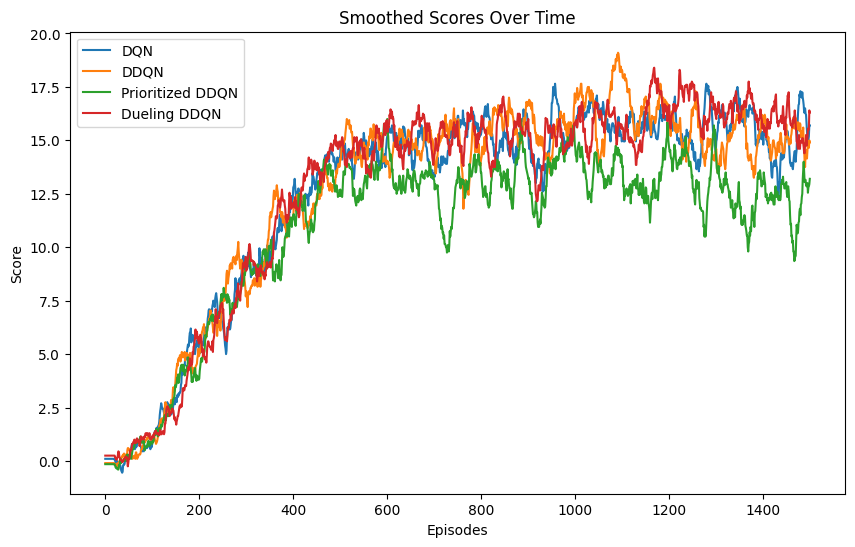

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

def load_data(json_file):
    # Load arrays from JSON file
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Assuming the JSON has four arrays named 'line1', 'line2', etc.
    line1 = np.array(data['DQN']["episodes_data"]["episodes"])
    line2 = np.array(data['DDQN']["episodes_data"]["episodes"])
    line3 = np.array(data['Prioritized DDQN']["episodes_data"]["episodes"])
    line4 = np.array(data['Dueling DDQN']["episodes_data"]["episodes"])
    return line1, line2, line3, line4

def smooth_data(data, window_size=20):
    # Apply moving average smoothing
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_smoothed_lines(DQN, DDQN, PrioDDQN, DuelingDDQN):
    # Smooth each line
    line1_smooth = smooth_data(DQN)
    line2_smooth = smooth_data(DDQN)
    line3_smooth = smooth_data(PrioDDQN)
    line4_smooth = smooth_data(DuelingDDQN)
    
    # Plot the smoothed lines
    plt.figure(figsize=(10, 6))
    plt.plot(line1_smooth, label="DQN")
    plt.plot(line2_smooth, label="DDQN")
    plt.plot(line3_smooth, label="Prioritized DDQN")
    plt.plot(line4_smooth, label="Dueling DDQN")
    
    # Add labels and legend
    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.title("Smoothed Scores Over Time")
    plt.legend()
    plt.show()

# Load data
DQN, DDQN, PrioDDQN, DuelingDDQN = load_data('performance.json')

# Plot smoothed lines
plot_smoothed_lines(DQN, DDQN, PrioDDQN, DuelingDDQN)